In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFile

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from pytorch_grad_cam import GradCAM#, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
#from torchvision.models import resnet50

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import os
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
from functions import(import_train_folder_dataset,
                      Data,
                      plot_loss_accuracy,
                      save_model,
                      save_metrics,
                      import_test_folder_dataset,
                      Data_test,
                      save_predictions_as_csv
                     )

In [6]:
import itertools

# Parameters

In [9]:
model_epochs = 100 # 100

lr = 0.006 # Learning rate.
                            
#torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 6
TEST_BATCH_SIZE = 6

checkpoints_save = 10 # Save after 50 epochs
BBOX_THRESHOLD = 0.75 # From 0-1

model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/CheckPoints/"
PATH = "D:\\Personal\\Alex\\Uni\\MS IA\\2 Curso\\Fall 2022\Artificial Intelligence\\Projects\\Project 1\\Models Save\\GoogleNet_CAM-Plus-ImgClass_v3\\"


cuda


# Import Data

In [10]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [11]:
img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((400, 400)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Train-Val Data

In [12]:
# Import the data 
train_data, train_labels = import_train_folder_dataset(train_data_path)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)
print("Classes distribution: ", np.unique(train_labels,return_counts=True)[1]/np.sum(np.unique(train_labels,return_counts=True)[1]))

C:\Users\Alex\Jupyter NoteBook Master\IA Master\Fall 2022\Artificial Intelligence\Final Project\GoogleNet_CAM-Plus-ImgClass_v3\functions.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return( np.array(img_data_files),np.array(label_data_files) )


Dim of Data:  (1149,)
Dim of Lables:  (1149,)
Classes distribution:  [0.39164491 0.42732811 0.16275022 0.01827676]


In [13]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True, 
                                                  stratify=train_labels)
print("Dim of X_train: ", X_train.shape)
print("Dim of y_train: ", y_train.shape)
print("Train Data distribution", np.unique(y_train,return_counts=True)[1]/np.sum(np.unique(y_train,return_counts=True)[1]))
print("Dim of X_val: ", X_val.shape)
print("Dim of y_val: ", y_val.shape)
print("Val Data distribution: ", np.unique(y_val,return_counts=True)[1]/np.sum(np.unique(y_val,return_counts=True)[1]))

Dim of X_train:  (1034,)
Dim of y_train:  (1034,)
Train Data distribution [0.39168279 0.42746615 0.16247582 0.01837524]
Dim of X_val:  (115,)
Dim of y_val:  (115,)
Val Data distribution:  [0.39130435 0.42608696 0.16521739 0.0173913 ]


In [14]:
# Create the dataset object
train_Dataset = Data(X_train, y_train, img_transform_val) # img_transform
val_Dataset = Data(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [15]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

# Create Model

### Model 1, to extract the BBOX

In [16]:
# Load model
model_save = "weights_googlenet_0.7763157894736842_best.pt"
model_bbox = torch.load(PATH+model_save, map_location=device).to(device)



# Create the model

# Define the Target Layers, for CAM
target_layers = [model_bbox.inception5b.branch4]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_bbox, target_layers=target_layers, use_cuda=torch.cuda.is_available())#

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
trainable_parameters_1 = filter(lambda p: p.requires_grad, model_bbox.parameters())
#optimizer = torch.optim.Adam(params=trainable_parameters_1, lr=lr)
optimizer = torch.optim.SGD(params=trainable_parameters_1, lr=lr, momentum=1e-5)  

# Check if checkpoint is available, if so, load it
model_epoch_m1_check = 0
previous_time = 0

model_bbox

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
# Check if checkpoint is available, if so, load it
model_epoch_m1_check = 0
previous_time = 0

names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m1.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m1.pth")
        model_bbox.load_state_dict(checkpoint['model_state_dict'])
        model_bbox.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m1_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m1_check}")

Loading save chackpoint
Epoch of the checkpoint: 25


### Model 2, to make clasification

In [18]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self, googlenet):
        super(ClassificationNet, self).__init__()
        # get the pretrained googlenet network
        #self.googlenet = models.googlenet(pretrained=True)
        #self.resnet50 = models.resnet50(pretrained=True)
        
        # Get the feature extractor
        self.googlenet_fe = nn.Sequential(*list(googlenet.children())[:-1])
        #self.resnet50_fe = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Flatten the FE output
        self.flatten = nn.Flatten()
        
        # Add a clissifier
        #self.last_classifier =  nn.Linear(in_features=2048, out_features=4)
        self.last_classifier =  nn.Linear(in_features=1024, out_features=4)
        
    def forward(self, x): 
        #x = self.resnet50_fe(x)
        x = self.googlenet_fe(x)
        
        x = self.flatten(x)
        
        x = self.last_classifier(x)
        
        return x

modelpy = ClassificationNet(googlenet = models.googlenet(pretrained=True)).to(device)

# Loss Function
criterion_2 = nn.CrossEntropyLoss()

# Optimizer    
trainable_parameters_2 = filter(lambda p: p.requires_grad, modelpy.parameters())
#optimizer_2 = torch.optim.Adam(params=trainable_parameters_2, lr=lr)
optimizer_2 = torch.optim.SGD(params=trainable_parameters_2, lr=lr, momentum=1e-5) 

# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0

modelpy

D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Users\Alex\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

In [19]:
# Check if checkpoint is available, if so, load it
model_epoch_m2_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt_m2.pth"):
        print("Loading save checkpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt_m2.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optimizer_2.load_state_dict(checkpoint['optimizer_state_dict'])
        model_epoch_m2_check = checkpoint['epoch']
        criterion_2 = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {model_epoch_m2_check}")


Loading save checkpoint
Epoch of the checkpoint: 25


# Functions for BBOX

In [20]:
def get_heatmap(image, device, cam_function):
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam_function(input_tensor=image.to(device), targets=None)

    return grayscale_cam

In [21]:
def bbox(heat_img, threshold, dim = (224,224)):
    H, W = heat_img.shape
    # Create Copy
    heat_2 = np.copy(heat_img)
    # Apply thershold
    heat_2[ heat_2 > threshold ] = 255
    heat_2[ heat_2 != 255 ] = 0
    
    up_bound_coord = -1
    down_bound_coord = -1
    for i in range(len(heat_2)):
        # Uper bound
        up_row = heat_2[i]
        if(up_bound_coord==-1 and 255 in up_row):
            # check if there is image in this row
            up_bound_coord = i
            
        # Lower bound
        low_row = heat_2[-(i+1)]
        if(down_bound_coord==-1 and 255 in low_row):
            # check if there is image in this row
            down_bound_coord = len(heat_2) - (i)
        
    left_bound_coord = -1
    right_bound_coord = -1
    for i in range(len(heat_2[0])):
        # left bound
        left_row = heat_2[:,i]
        if(left_bound_coord==-1 and 255 in left_row):
            # check if there is image in this row
            left_bound_coord = i
            
        # right bound
        right_row = heat_2[:,-(i+1)]
        if(right_bound_coord==-1 and 255 in right_row):
            # check if there is image in this row
            right_bound_coord = len(heat_2) - (i)
    
    return np.array([left_bound_coord*(dim[0]/H), up_bound_coord*(dim[1]/W), right_bound_coord*(dim[0]/H), down_bound_coord*(dim[1]/W)])



# Given a set of images, return the croped versions, based on the cams
def get_cropped_img_batch_base_on_CAM(batch, device, cam_function, threshold = 0.75):
    
    size = (batch.shape[2], batch.shape[3])
    
    
    heat_list = get_heatmap(batch, device, cam_function)
    
    outx = []
    outbox = []
    for img, heat in zip(batch, heat_list):
        box = bbox(heat, threshold = threshold, dim = size)
        
        # Crop the Img
        img_crop = img[:,int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        
        # Resize cropped img to original size
        rr = transforms.Compose([transforms.Resize(size)])
        img_resize = rr(img_crop)
        
        outx.append(img_resize)
        outbox.append(box)
    outx2 = torch.stack(outx, 0)
    return outx2, outbox

## Bbox Before Training

In [22]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [23]:
# Use the model to make prediction on 1 sample. return the img, the real values and predictions
def get_true_values_and_predictions(model, t_Dataset, img_number, cam_function, threshold=0.75):
    # Make Prediction for Train Img
    model.eval()
    x_draw, y_draw_real = t_Dataset[img_number]

    # Invert norm of img, to plot it
    x_draw_inv = invTrans(x_draw)
    # Reorder the Axis
    x_draw_inv = np.moveaxis(x_draw_inv.numpy(), 0, -1)

    # Add dimension
    x_tensor = x_draw[None, :].to(device)
    
    # get the heatmap
    heat = get_heatmap(x_tensor, device, cam_function)[0]
    
    # calculate the bbox
    b_draw_pred = bbox(heat, threshold, dim = x_tensor.shape[2:4])
    
    print(f"Img shape: {x_draw_inv.shape}")

    print(f"Bbox pred: {b_draw_pred}")
    
    print(f"Label real: {y_draw_real.item()}")
        
    return x_draw_inv, y_draw_real.item(), heat, b_draw_pred


# Creates an Img with the Real BBOX and Label and another one with the predction BBOX and Label
def create_img_and_bbox_with_pred(img, pred_bbox):
    im = img.copy()
    im_cut = img.copy()
    
    print(f"Size of img: {im.shape}")
    # Add Bbox 
    real = cv2.rectangle(im, 
                         (int(pred_bbox[0]),int(pred_bbox[1])), 
                         (int(pred_bbox[2]-1),int(pred_bbox[3]-1)), 
                         (255, 0, 0), 2) #(0, 0, 255)
    
    # Crop the Img
    img_crop = im_cut[int(pred_bbox[1]):int(pred_bbox[3]), int(pred_bbox[0]):int(pred_bbox[2])]
    
    # Resize 
    resized_img_crop = cv2.resize(img_crop, (img.shape[0], img.shape[1]))
    
    return real, resized_img_crop

Img shape: (400, 400, 3)
Bbox pred: [100. 118. 293. 262.]
Label real: 0
Size of img: (400, 400, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


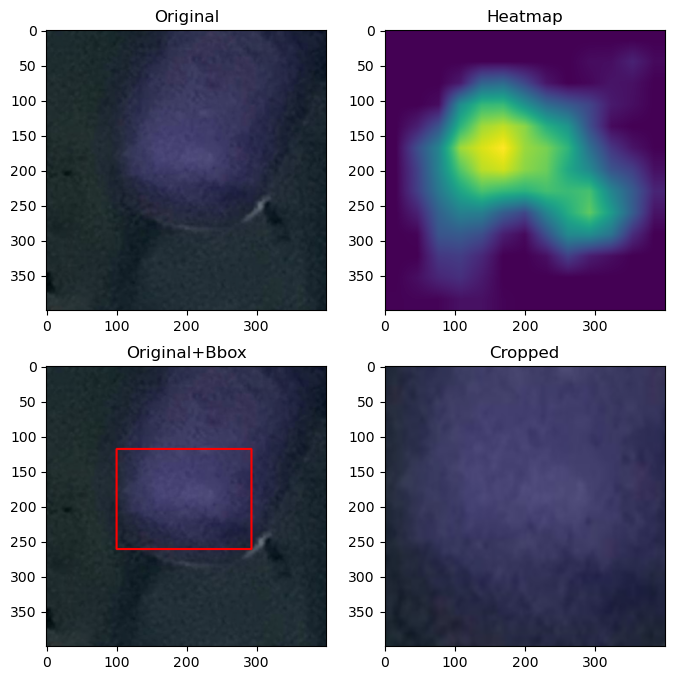

In [22]:
img_number = 1
# Create heatmap and Bbox
real_img, real_label, pred_heat, pred_box =get_true_values_and_predictions(model_bbox, val_Dataset, img_number, cam, threshold=BBOX_THRESHOLD)
# Compose img of real img+Bbox and croped Image
rr, rr_crop = create_img_and_bbox_with_pred(real_img, pred_box)

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
ax1.imshow(real_img)
ax1.title.set_text("Original")
ax2.imshow(pred_heat)
ax2.title.set_text("Heatmap")
ax3.imshow(rr)
ax3.title.set_text("Original+Bbox")
ax4.imshow(rr_crop)
ax4.title.set_text("Cropped")
plt.show()

# Train Model

In [24]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"]=lr

Loading Metrics
Epoch 26 of 100


100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


train loss:  0.111656219631837
Val loss:  0.10538338500520457
train accuracy:  0.7379110251450677
Val accuracy:  0.7565217391304347
Current time: 88.386 minutes. Time expected till completion: 251.560 minutes
Epoch 27 of 100


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


train loss:  0.11293982011148962
Val loss:  0.10659449087536853
train accuracy:  0.7224371373307543
Val accuracy:  0.782608695652174
Current time: 91.642 minutes. Time expected till completion: 247.772 minutes
Epoch 28 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.11187551798915032
Val loss:  0.10451738912126292
train accuracy:  0.7408123791102514
Val accuracy:  0.7652173913043478
Current time: 94.873 minutes. Time expected till completion: 243.959 minutes
Epoch 29 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.10978802338213708
Val loss:  0.11083605619876281
train accuracy:  0.7350096711798839
Val accuracy:  0.7478260869565218
Current time: 98.050 minutes. Time expected till completion: 240.052 minutes
Epoch 30 of 100


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


train loss:  0.11127223207019053
Val loss:  0.10428767774416053
train accuracy:  0.7127659574468085
Val accuracy:  0.782608695652174
Saving model 1 checkpoint
Saving model 2 checkpoint


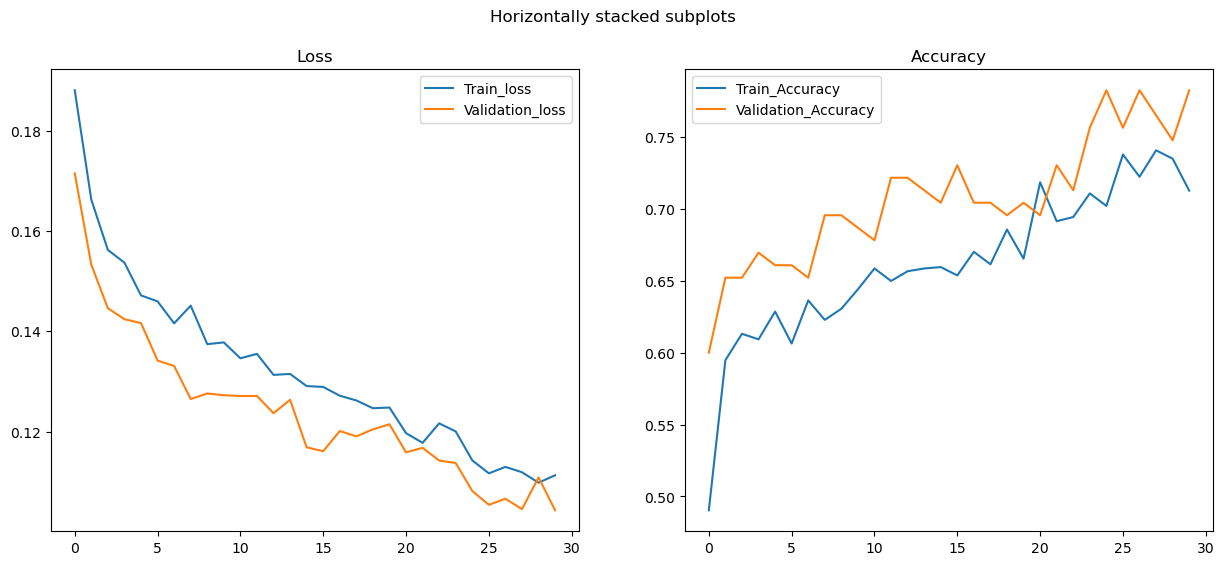

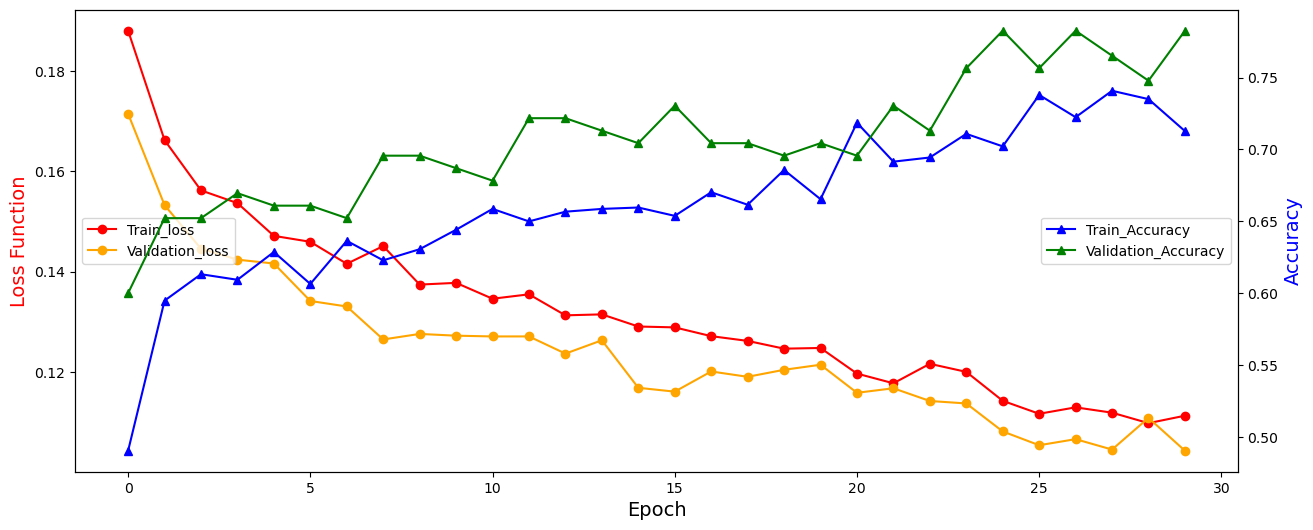

Current time: 101.583 minutes. Time expected till completion: 237.027 minutes
Epoch 31 of 100


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


train loss:  0.10613132289807155
Val loss:  0.10491373526013416
train accuracy:  0.7350096711798839
Val accuracy:  0.7565217391304347
Current time: 104.761 minutes. Time expected till completion: 233.178 minutes
Epoch 32 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.1015727178444023
Val loss:  0.11386126577854157
train accuracy:  0.7640232108317214
Val accuracy:  0.7391304347826086
Current time: 107.936 minutes. Time expected till completion: 229.364 minutes
Epoch 33 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.10696980243321774
Val loss:  0.11886577450710795
train accuracy:  0.741779497098646
Val accuracy:  0.7304347826086957
Current time: 111.108 minutes. Time expected till completion: 225.583 minutes
Epoch 34 of 100


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


train loss:  0.10521559636297724
Val loss:  0.09633305007996766
train accuracy:  0.7572533849129593
Val accuracy:  0.782608695652174
Current time: 114.290 minutes. Time expected till completion: 221.856 minutes
Epoch 35 of 100


100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


train loss:  0.09908483465647099
Val loss:  0.10420578251714292
train accuracy:  0.7659574468085106
Val accuracy:  0.7565217391304347
Current time: 117.493 minutes. Time expected till completion: 218.201 minutes
Epoch 36 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.09995310893372364
Val loss:  0.10475924338983453
train accuracy:  0.7678916827852998
Val accuracy:  0.7478260869565218
Current time: 120.698 minutes. Time expected till completion: 214.575 minutes
Epoch 37 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.09599534027292835
Val loss:  0.10274233494115913
train accuracy:  0.7736943907156673
Val accuracy:  0.7739130434782608
Current time: 123.903 minutes. Time expected till completion: 210.970 minutes
Epoch 38 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.09798970897781088
Val loss:  0.10160675826280013
train accuracy:  0.7688588007736944
Val accuracy:  0.808695652173913
Best model at the moment with Val_acc 80.87, saving...
Current time: 127.140 minutes. Time expected till completion: 207.439 minutes
Epoch 39 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.09636854181494887
Val loss:  0.1030999700660291
train accuracy:  0.7669245647969052
Val accuracy:  0.8
Current time: 130.337 minutes. Time expected till completion: 203.860 minutes
Epoch 40 of 100


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


train loss:  0.09234172115877011
Val loss:  0.10381951979968859
train accuracy:  0.7959381044487428
Val accuracy:  0.782608695652174
Saving model 1 checkpoint
Saving model 2 checkpoint


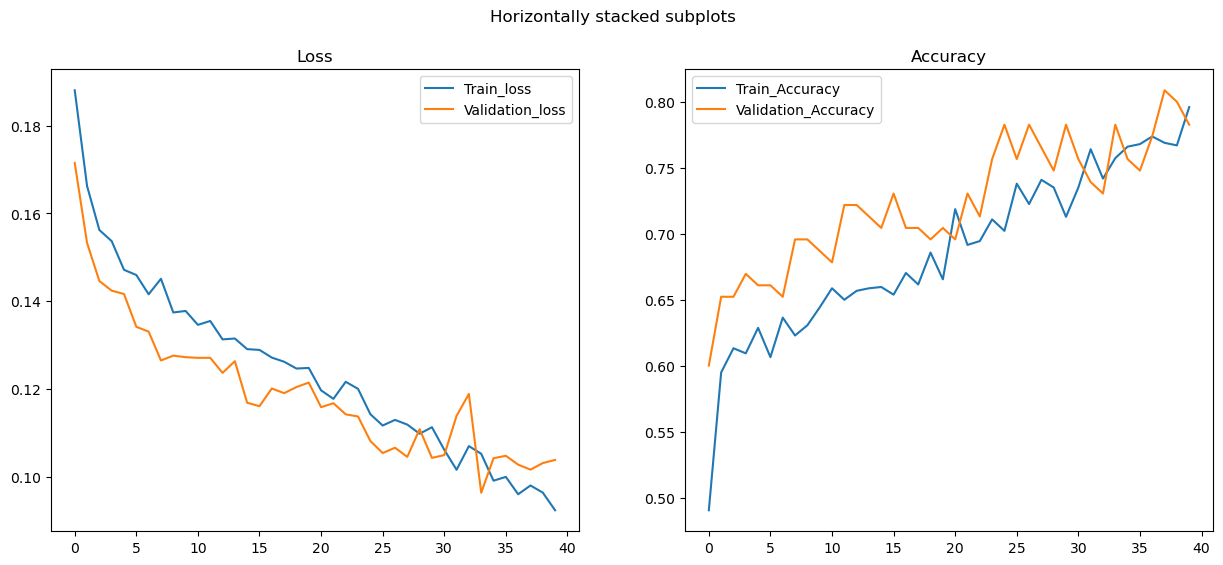

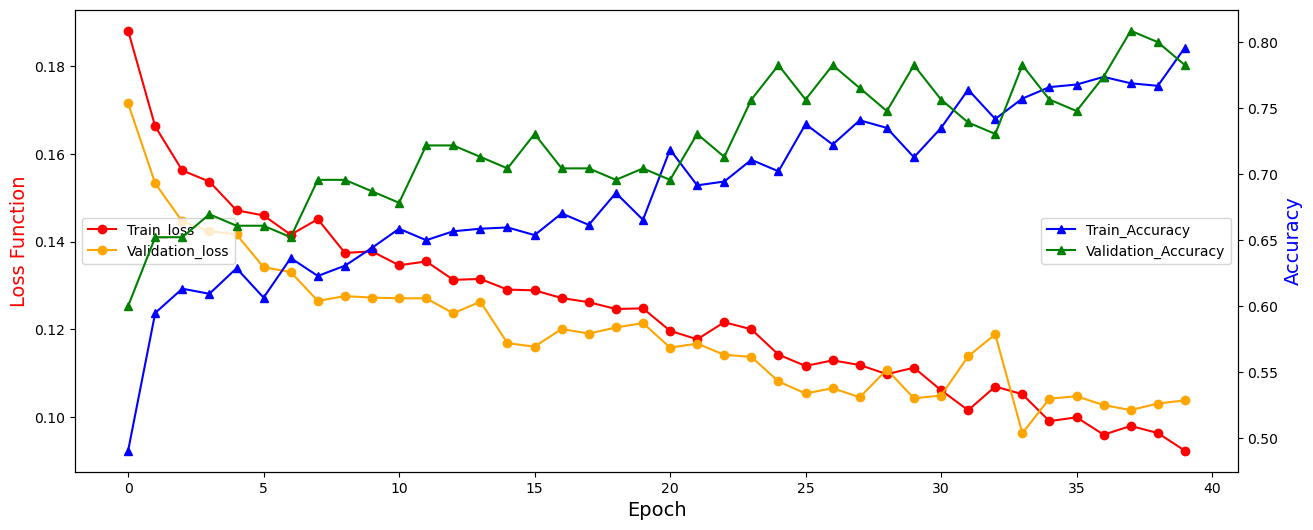

Current time: 133.590 minutes. Time expected till completion: 200.385 minutes
Epoch 41 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.09031873999066233
Val loss:  0.10432761628990588
train accuracy:  0.7901353965183753
Val accuracy:  0.7652173913043478
Current time: 136.771 minutes. Time expected till completion: 196.817 minutes
Epoch 42 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.09001208618427384
Val loss:  0.10860682026199672
train accuracy:  0.8056092843326886
Val accuracy:  0.782608695652174
Current time: 139.970 minutes. Time expected till completion: 193.292 minutes
Epoch 43 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.09428916097667277
Val loss:  0.11368821677954301
train accuracy:  0.7794970986460348
Val accuracy:  0.7304347826086957
Current time: 143.177 minutes. Time expected till completion: 189.792 minutes
Epoch 44 of 100


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


train loss:  0.0909136419384461
Val loss:  0.10825120638246122
train accuracy:  0.7785299806576402
Val accuracy:  0.7478260869565218
Current time: 146.364 minutes. Time expected till completion: 186.282 minutes
Epoch 45 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.09217794385073955
Val loss:  0.10744998636453049
train accuracy:  0.781431334622824
Val accuracy:  0.7391304347826086
Current time: 149.540 minutes. Time expected till completion: 182.771 minutes
Epoch 46 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.0881213060430678
Val loss:  0.09874214147743972
train accuracy:  0.8017408123791102
Val accuracy:  0.8
Current time: 152.711 minutes. Time expected till completion: 179.269 minutes
Epoch 47 of 100


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


train loss:  0.0866943353091725
Val loss:  0.09448873400688171
train accuracy:  0.8075435203094777
Val accuracy:  0.782608695652174
Current time: 155.878 minutes. Time expected till completion: 175.778 minutes
Epoch 48 of 100


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


train loss:  0.08359364216977899
Val loss:  0.12816037354261978
train accuracy:  0.8172147001934236
Val accuracy:  0.7739130434782608
Current time: 159.047 minutes. Time expected till completion: 172.300 minutes
Epoch 49 of 100


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


train loss:  0.08570175156054921
Val loss:  0.11146284853634628
train accuracy:  0.8133462282398453
Val accuracy:  0.7913043478260869
Current time: 162.211 minutes. Time expected till completion: 168.832 minutes
Epoch 50 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.08103597081289762
Val loss:  0.11385078106237495
train accuracy:  0.8123791102514507
Val accuracy:  0.7391304347826086
Saving model 1 checkpoint
Saving model 2 checkpoint


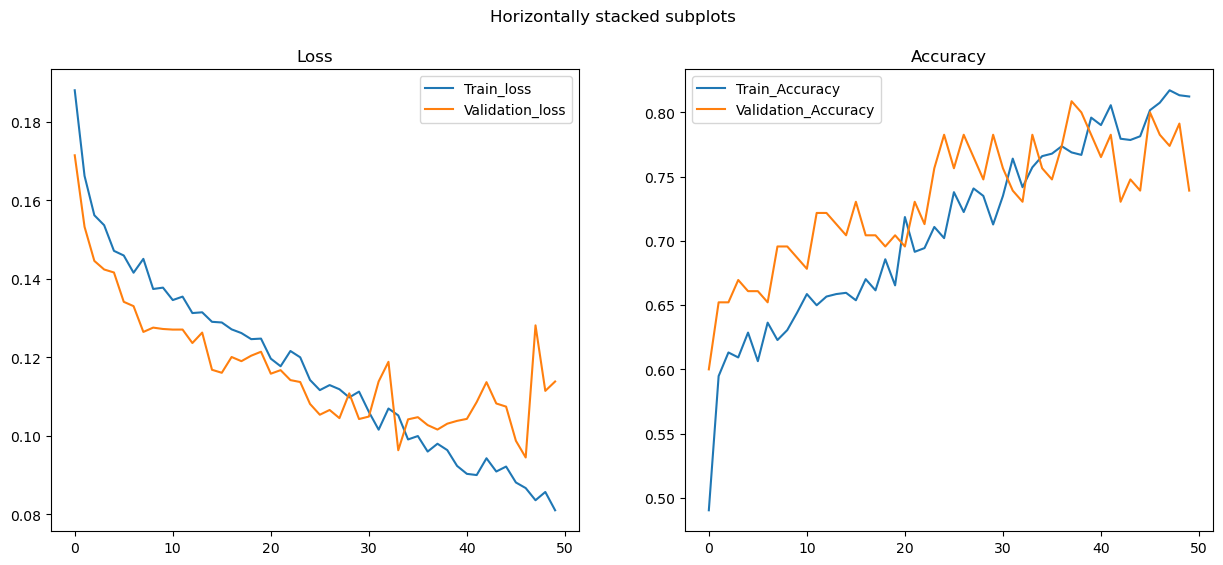

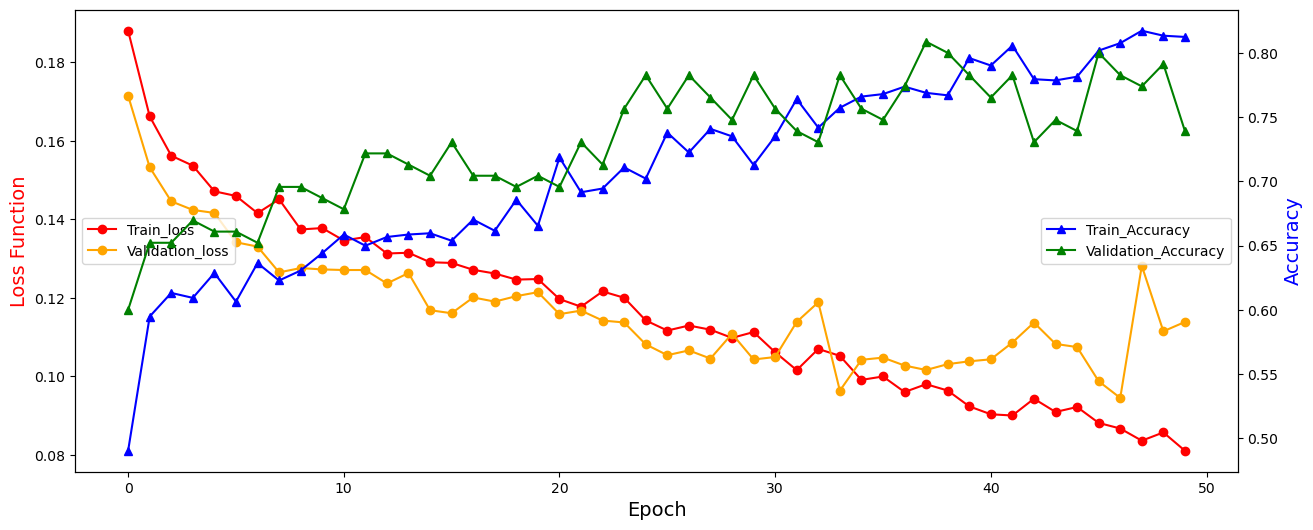

Current time: 165.564 minutes. Time expected till completion: 165.564 minutes
Epoch 51 of 100


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


train loss:  0.08273973351982161
Val loss:  0.09529652601998785
train accuracy:  0.816247582205029
Val accuracy:  0.8
Current time: 168.735 minutes. Time expected till completion: 162.118 minutes
Epoch 52 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.07933831472144366
Val loss:  0.09985650026279946
train accuracy:  0.8220502901353965
Val accuracy:  0.7913043478260869
Current time: 171.921 minutes. Time expected till completion: 158.696 minutes
Epoch 53 of 100


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


train loss:  0.08341858412789423
Val loss:  0.11474270094995913
train accuracy:  0.8085106382978723
Val accuracy:  0.7304347826086957
Current time: 175.115 minutes. Time expected till completion: 155.290 minutes
Epoch 54 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.07863371019076909
Val loss:  0.11226434736796047
train accuracy:  0.8230174081237911
Val accuracy:  0.7391304347826086
Current time: 178.307 minutes. Time expected till completion: 151.891 minutes
Epoch 55 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.07799475706349951
Val loss:  0.1105968955418338
train accuracy:  0.8288201160541586
Val accuracy:  0.7913043478260869
Current time: 181.507 minutes. Time expected till completion: 148.506 minutes
Epoch 56 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.07917458267172715
Val loss:  0.10221572822850683
train accuracy:  0.8249516441005803
Val accuracy:  0.7739130434782608
Current time: 184.711 minutes. Time expected till completion: 145.130 minutes
Epoch 57 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.0753078632762861
Val loss:  0.11158578881750936
train accuracy:  0.8375241779497099
Val accuracy:  0.7913043478260869
Current time: 187.907 minutes. Time expected till completion: 141.754 minutes
Epoch 58 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.07389956268858403
Val loss:  0.10533466799103695
train accuracy:  0.8423597678916828
Val accuracy:  0.7565217391304347
Current time: 191.087 minutes. Time expected till completion: 138.373 minutes
Epoch 59 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.07355211080705866
Val loss:  0.09655463196661161
train accuracy:  0.8433268858800773
Val accuracy:  0.782608695652174
Current time: 194.267 minutes. Time expected till completion: 134.999 minutes
Epoch 60 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.07168692226811696
Val loss:  0.08328921166451081
train accuracy:  0.8520309477756286
Val accuracy:  0.808695652173913
Saving model 1 checkpoint
Saving model 2 checkpoint


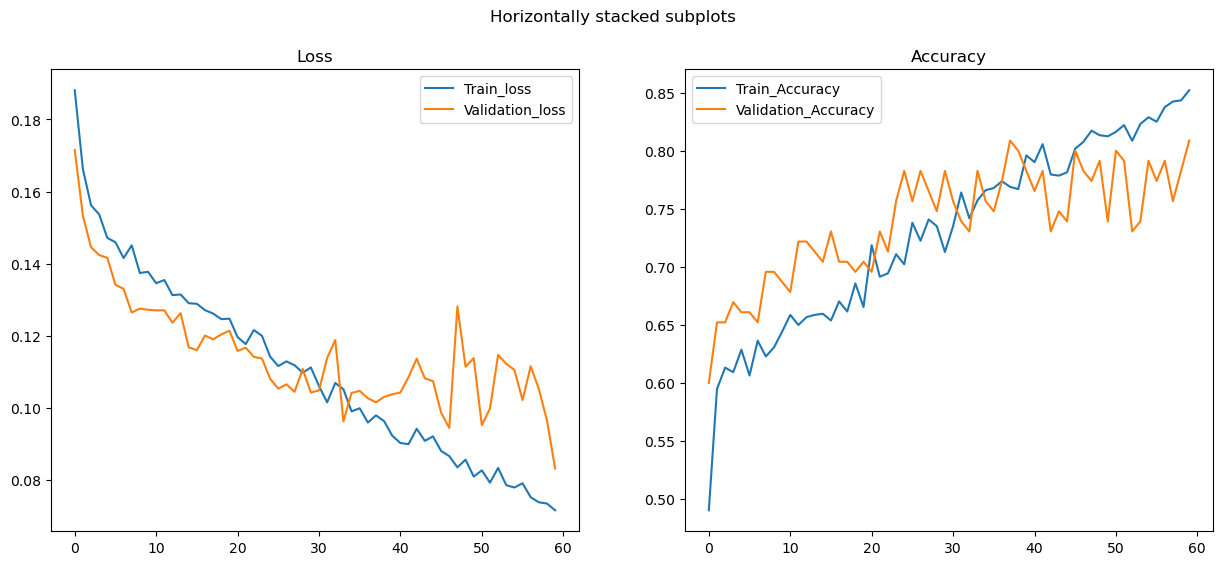

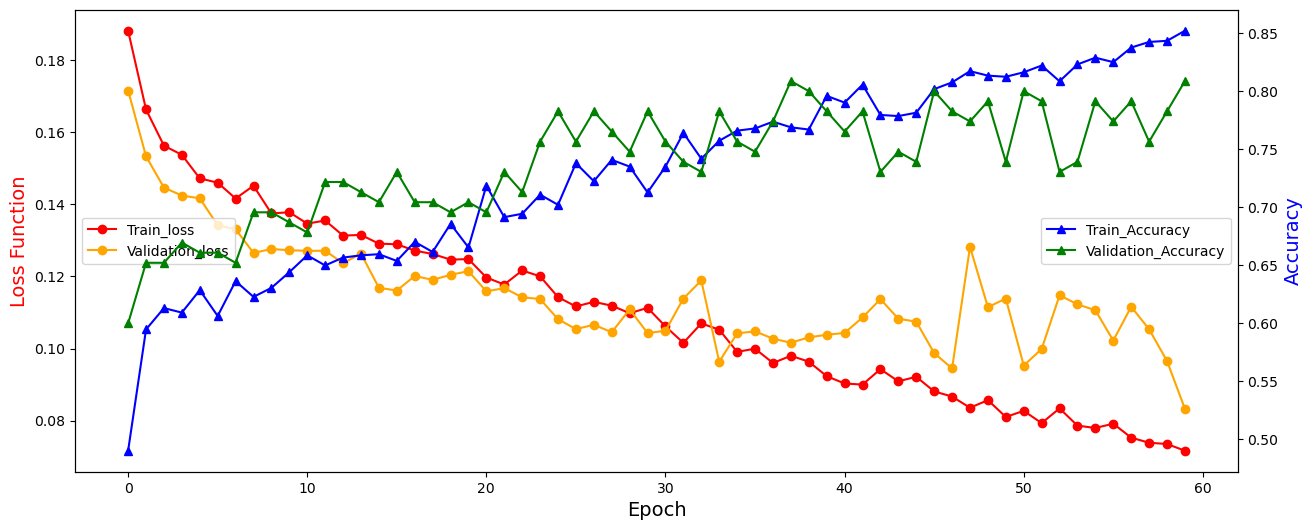

Current time: 197.471 minutes. Time expected till completion: 131.647 minutes
Epoch 61 of 100


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


train loss:  0.06963149617413487
Val loss:  0.10654012956049132
train accuracy:  0.8317214700193424
Val accuracy:  0.7652173913043478
Current time: 200.650 minutes. Time expected till completion: 128.284 minutes
Epoch 62 of 100


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


train loss:  0.06703052279941119
Val loss:  0.107030581391376
train accuracy:  0.8588007736943907
Val accuracy:  0.7913043478260869
Current time: 203.820 minutes. Time expected till completion: 124.922 minutes
Epoch 63 of 100


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


train loss:  0.06734260027900309
Val loss:  0.13085222140602443
train accuracy:  0.8568665377176016
Val accuracy:  0.7130434782608696
Current time: 206.993 minutes. Time expected till completion: 121.567 minutes
Epoch 64 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.06106314571426616
Val loss:  0.10781524563613146
train accuracy:  0.8684719535783365
Val accuracy:  0.782608695652174
Current time: 210.154 minutes. Time expected till completion: 118.212 minutes
Epoch 65 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.06746532639751582
Val loss:  0.11812317345453345
train accuracy:  0.8491295938104448
Val accuracy:  0.7913043478260869
Current time: 213.320 minutes. Time expected till completion: 114.865 minutes
Epoch 66 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.06508524091896283
Val loss:  0.10974019215158794
train accuracy:  0.8588007736943907
Val accuracy:  0.7565217391304347
Current time: 216.491 minutes. Time expected till completion: 111.526 minutes
Epoch 67 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.06314775782206763
Val loss:  0.09749535192614016
train accuracy:  0.8520309477756286
Val accuracy:  0.808695652173913
Current time: 219.654 minutes. Time expected till completion: 108.188 minutes
Epoch 68 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.05413422571059237
Val loss:  0.10715218912000242
train accuracy:  0.8858800773694391
Val accuracy:  0.782608695652174
Current time: 222.823 minutes. Time expected till completion: 104.858 minutes
Epoch 69 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.059500950491290026
Val loss:  0.09314417524830154
train accuracy:  0.8694390715667312
Val accuracy:  0.7913043478260869
Current time: 225.991 minutes. Time expected till completion: 101.532 minutes
Epoch 70 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.06510134401228602
Val loss:  0.1096430360623028
train accuracy:  0.8471953578336557
Val accuracy:  0.7478260869565218
Saving model 1 checkpoint
Saving model 2 checkpoint


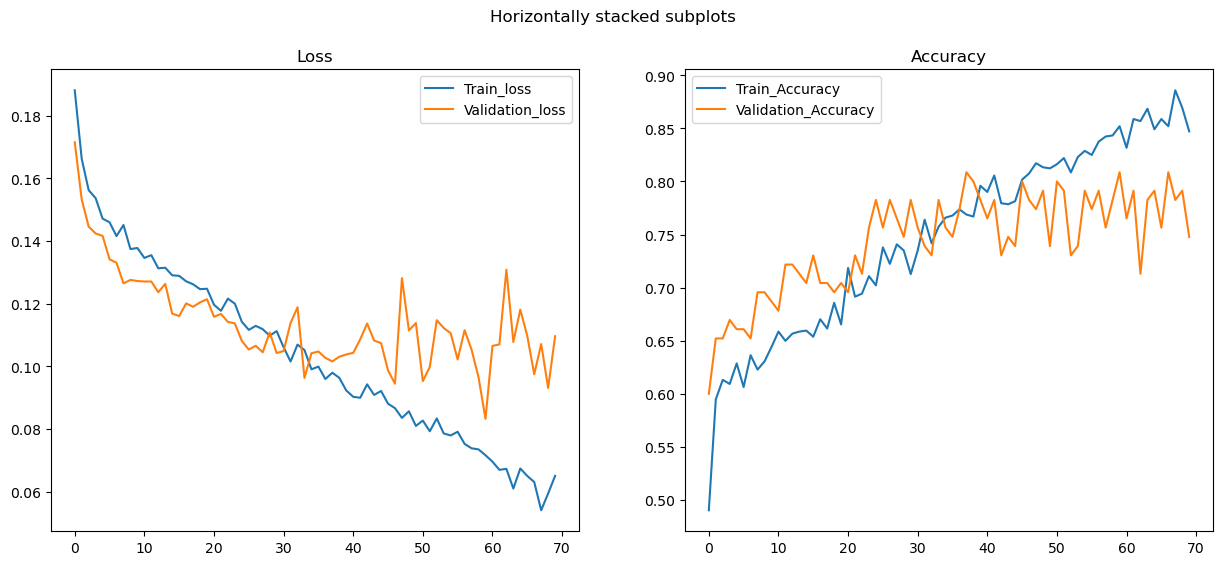

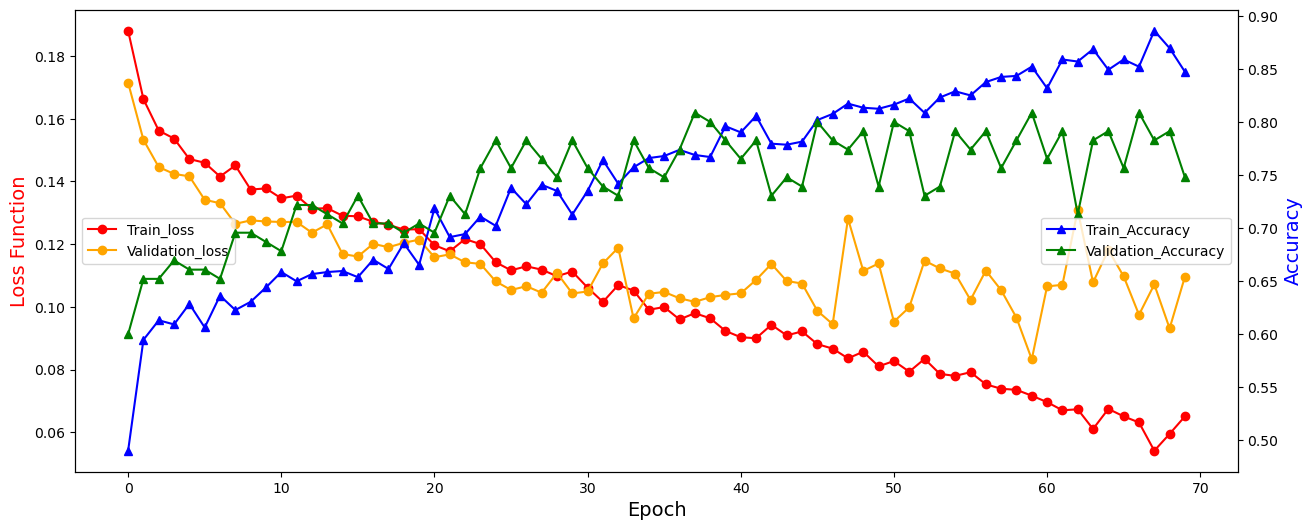

Current time: 229.215 minutes. Time expected till completion: 98.235 minutes
Epoch 71 of 100


100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


train loss:  0.05702437955806864
Val loss:  0.10121420244483845
train accuracy:  0.8704061895551257
Val accuracy:  0.782608695652174
Current time: 232.392 minutes. Time expected till completion: 94.921 minutes
Epoch 72 of 100


100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


train loss:  0.059623049496451475
Val loss:  0.12185035704270653
train accuracy:  0.867504835589942
Val accuracy:  0.7217391304347827
Current time: 235.576 minutes. Time expected till completion: 91.613 minutes
Epoch 73 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.05394012168972128
Val loss:  0.10651899349430333
train accuracy:  0.8916827852998066
Val accuracy:  0.7391304347826086
Current time: 238.755 minutes. Time expected till completion: 88.307 minutes
Epoch 74 of 100


100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


train loss:  0.054836957564134314
Val loss:  0.09846522723850996
train accuracy:  0.8849129593810445
Val accuracy:  0.7913043478260869
Current time: 241.935 minutes. Time expected till completion: 85.004 minutes
Epoch 75 of 100


100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


train loss:  0.05434795424731257
Val loss:  0.10590347835551138
train accuracy:  0.8849129593810445
Val accuracy:  0.808695652173913
Current time: 245.127 minutes. Time expected till completion: 81.709 minutes
Epoch 76 of 100


100%|██████████| 20/20 [00:08<00:00,  2.37it/s]


train loss:  0.05284477261613831
Val loss:  0.10861904413803763
train accuracy:  0.8868471953578336
Val accuracy:  0.782608695652174
Current time: 248.317 minutes. Time expected till completion: 78.416 minutes
Epoch 77 of 100


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


train loss:  0.04716070304395959
Val loss:  0.10363202302352242
train accuracy:  0.8907156673114119
Val accuracy:  0.7565217391304347
Current time: 251.497 minutes. Time expected till completion: 75.123 minutes
Epoch 78 of 100


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


train loss:  0.050903490400464206
Val loss:  0.09594816704807074
train accuracy:  0.8936170212765957
Val accuracy:  0.7913043478260869
Current time: 254.671 minutes. Time expected till completion: 71.830 minutes
Epoch 79 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.04916728073568939
Val loss:  0.13070945663620595
train accuracy:  0.8887814313346228
Val accuracy:  0.6782608695652174
Current time: 257.844 minutes. Time expected till completion: 68.541 minutes
Epoch 80 of 100


100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


train loss:  0.05270326525924054
Val loss:  0.10759653342158898
train accuracy:  0.8800773694390716
Val accuracy:  0.7217391304347827
Saving model 1 checkpoint
Saving model 2 checkpoint


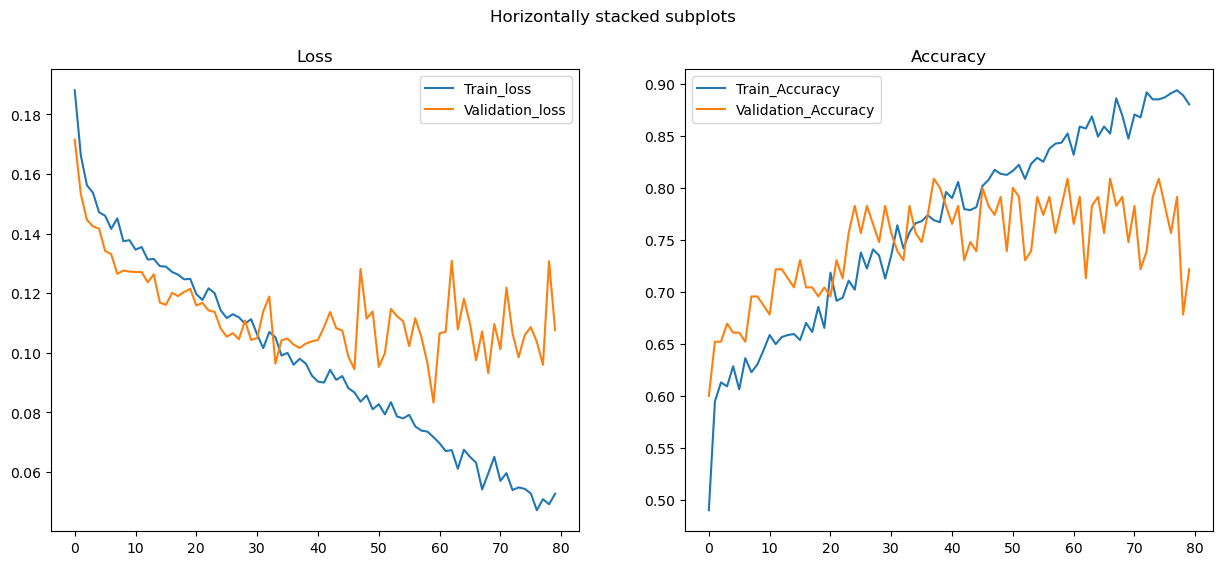

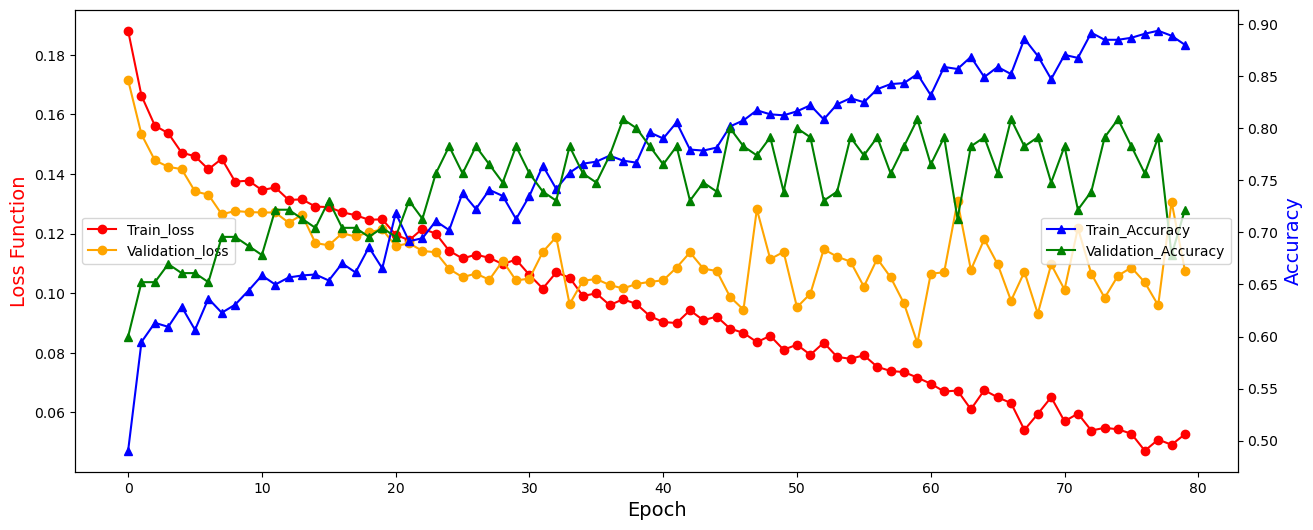

Current time: 261.044 minutes. Time expected till completion: 65.261 minutes
Epoch 81 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.04746505314019478
Val loss:  0.10701062598306199
train accuracy:  0.8974854932301741
Val accuracy:  0.7391304347826086
Current time: 264.210 minutes. Time expected till completion: 61.975 minutes
Epoch 82 of 100


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


train loss:  0.045618824318512496
Val loss:  0.10465959385037422
train accuracy:  0.902321083172147
Val accuracy:  0.7739130434782608
Current time: 267.375 minutes. Time expected till completion: 58.692 minutes
Epoch 83 of 100


100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


train loss:  0.052582651798251286
Val loss:  0.100664655815648
train accuracy:  0.8897485493230174
Val accuracy:  0.782608695652174
Current time: 270.540 minutes. Time expected till completion: 55.412 minutes
Epoch 84 of 100


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


train loss:  0.05260731593833613
Val loss:  0.10468226373195648
train accuracy:  0.8858800773694391
Val accuracy:  0.7913043478260869
Current time: 273.705 minutes. Time expected till completion: 52.134 minutes
Epoch 85 of 100


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


train loss:  0.04067880385762487
Val loss:  0.10455872597901718
train accuracy:  0.9129593810444874
Val accuracy:  0.7565217391304347
Current time: 276.873 minutes. Time expected till completion: 48.860 minutes
Epoch 86 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.042908338529041586
Val loss:  0.09695426177071488
train accuracy:  0.9081237911025145
Val accuracy:  0.7739130434782608
Current time: 280.033 minutes. Time expected till completion: 45.587 minutes
Epoch 87 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.043417729262615654
Val loss:  0.11997266168827596
train accuracy:  0.902321083172147
Val accuracy:  0.7652173913043478
Current time: 283.200 minutes. Time expected till completion: 42.317 minutes
Epoch 88 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.04413286763346057
Val loss:  0.11267354303727979
train accuracy:  0.9081237911025145
Val accuracy:  0.7304347826086957
Current time: 286.362 minutes. Time expected till completion: 39.049 minutes
Epoch 89 of 100


100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


train loss:  0.037303955895858644
Val loss:  0.1033925147322209
train accuracy:  0.9264990328820116
Val accuracy:  0.7739130434782608
Current time: 289.522 minutes. Time expected till completion: 35.784 minutes
Epoch 90 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.03873716802399325
Val loss:  0.1087945098300343
train accuracy:  0.9235976789168279
Val accuracy:  0.7565217391304347
Saving model 1 checkpoint
Saving model 2 checkpoint


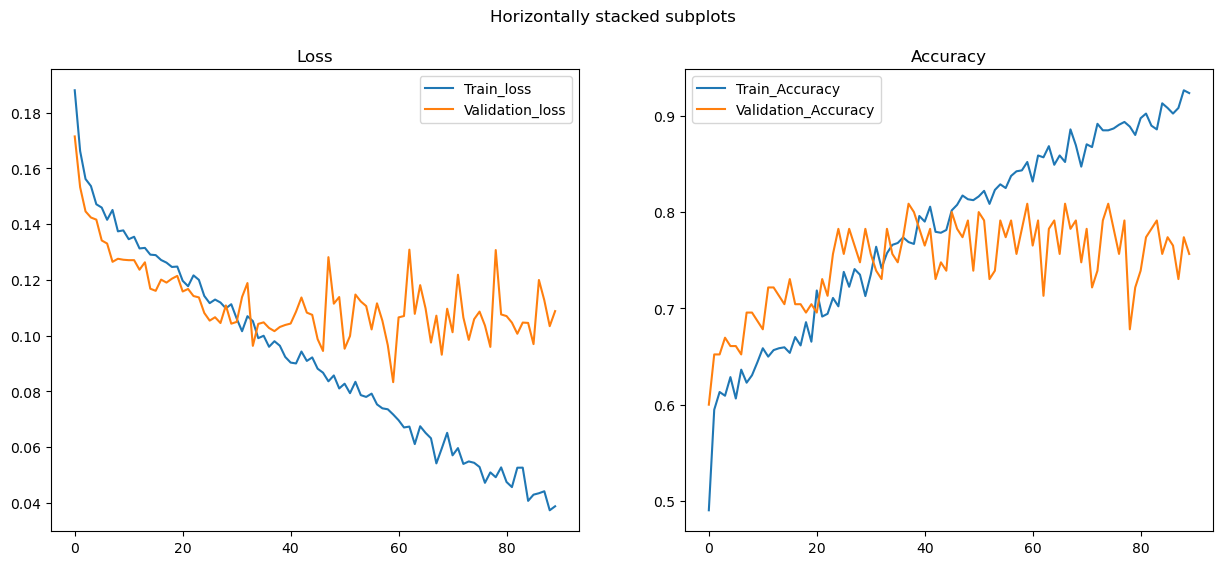

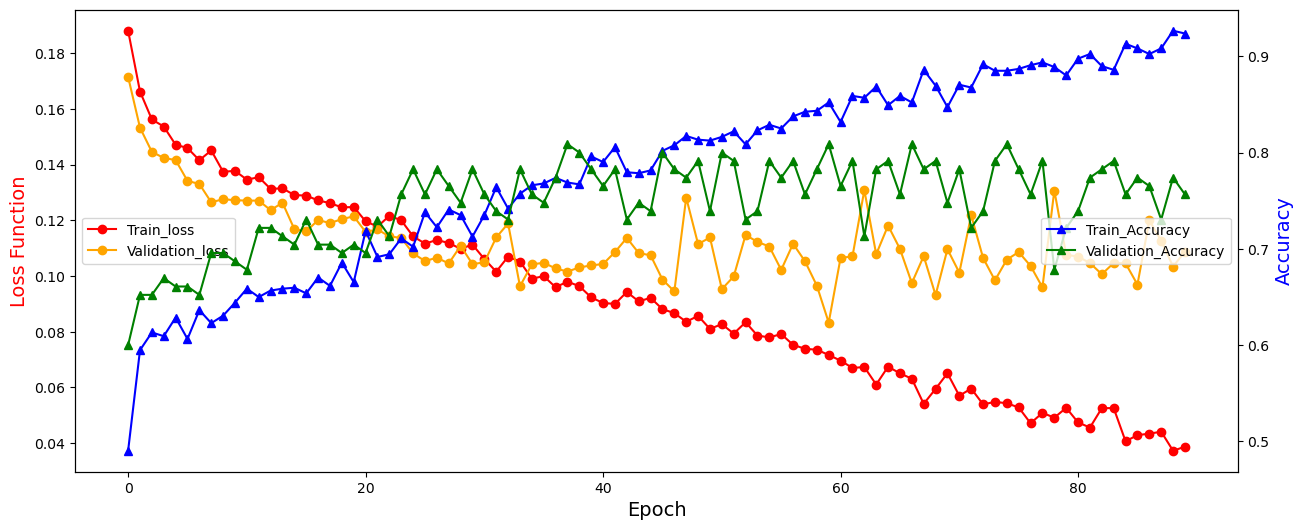

Current time: 292.708 minutes. Time expected till completion: 32.523 minutes
Epoch 91 of 100


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


train loss:  0.04185955846102141
Val loss:  0.1105267192358556
train accuracy:  0.90715667311412
Val accuracy:  0.7652173913043478
Current time: 295.877 minutes. Time expected till completion: 29.263 minutes
Epoch 92 of 100


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


train loss:  0.040393876264905794
Val loss:  0.11256348604093427
train accuracy:  0.9129593810444874
Val accuracy:  0.782608695652174
Current time: 299.037 minutes. Time expected till completion: 26.003 minutes
Epoch 93 of 100


100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


train loss:  0.04179066117236848
Val loss:  0.10014689883784107
train accuracy:  0.9081237911025145
Val accuracy:  0.8
Current time: 302.203 minutes. Time expected till completion: 22.746 minutes
Epoch 94 of 100


100%|██████████| 20/20 [00:09<00:00,  2.20it/s]


train loss:  0.04261623347823002
Val loss:  0.10937911174867464
train accuracy:  0.9206963249516441
Val accuracy:  0.782608695652174
Current time: 305.393 minutes. Time expected till completion: 19.493 minutes
Epoch 95 of 100


100%|██████████| 20/20 [00:08<00:00,  2.46it/s]


train loss:  0.038032923192794596
Val loss:  0.10240525619491286
train accuracy:  0.9226305609284333
Val accuracy:  0.808695652173913
Current time: 308.568 minutes. Time expected till completion: 16.240 minutes
Epoch 96 of 100


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


train loss:  0.03487685908035625
Val loss:  0.1145578471356598
train accuracy:  0.9284332688588007
Val accuracy:  0.808695652173913
Current time: 311.732 minutes. Time expected till completion: 12.989 minutes
Epoch 97 of 100


100%|██████████| 20/20 [00:07<00:00,  2.53it/s]


train loss:  0.03983650432550123
Val loss:  0.14371303757247716
train accuracy:  0.9284332688588007
Val accuracy:  0.7478260869565218
Current time: 314.890 minutes. Time expected till completion: 9.739 minutes
Epoch 98 of 100


100%|██████████| 20/20 [00:07<00:00,  2.54it/s]


train loss:  0.038721520178077645
Val loss:  0.09890985630614602
train accuracy:  0.9216634429400387
Val accuracy:  0.7478260869565218
Current time: 318.056 minutes. Time expected till completion: 6.491 minutes
Epoch 99 of 100


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]


train loss:  0.03236373493220924
Val loss:  0.11180320446905882
train accuracy:  0.937137330754352
Val accuracy:  0.7652173913043478
Current time: 321.216 minutes. Time expected till completion: 3.245 minutes
Epoch 100 of 100


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


train loss:  0.03596027921281784
Val loss:  0.10411564018577338
train accuracy:  0.9264990328820116
Val accuracy:  0.7739130434782608
Saving model 1 checkpoint
Saving model 2 checkpoint


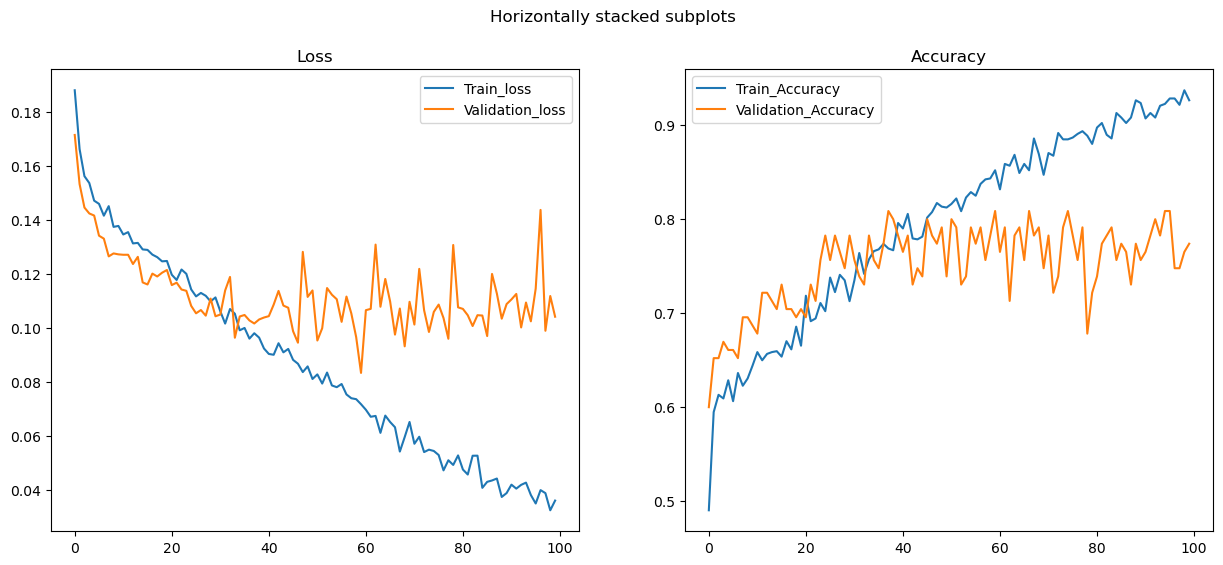

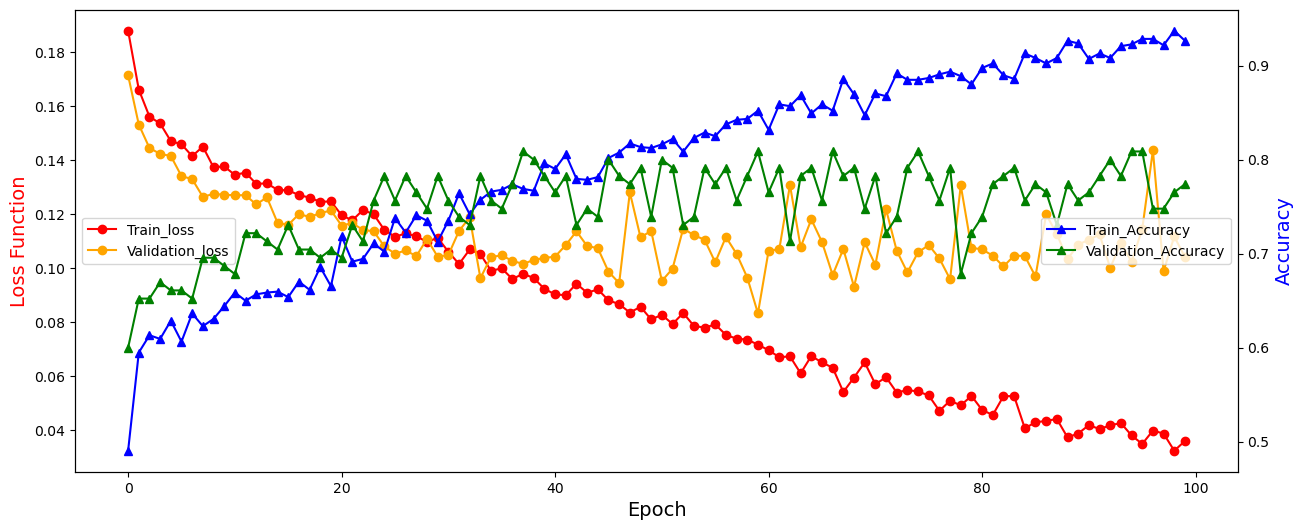

Current time: 324.409 minutes. Time expected till completion: 0.000 minutes
Finished training in: 324.409 minutes


In [25]:
best_model_val_acc = -1

train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy_m2.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy_m2.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
if(len(val_accuracy) >0):
    best_model_val_acc = max(val_accuracy)
        
# count time
start = time.time()

for epoch in range(model_epoch_m2_check, model_epochs):
    # Print current epoch
    print(f"Epoch {epoch + 1} of {model_epochs}")
    
    if(epoch%10 == 0):
        update_optimizer(optimizer, 0.001)
        update_optimizer(optimizer_2, 0.001)
    
    ############################################################################
    ################################ Train model ############################### 
    ############################################################################
    model_bbox.train()
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        
        #create the output from the CNN base on the give batch images
        out = model_bbox(images)
        # count the loss function 
        loss_1 = criterion(out, labels)
        
        # Set the model to evaluation only
        model_bbox.eval()
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images, _ = get_cropped_img_batch_base_on_CAM(images, device, cam, threshold = BBOX_THRESHOLD)#.to(device)
        new_images = new_images.to(device)
        # Set the model to train only
        model_bbox.train()
        
        
        
        
        # Optimize second model
        
        #create the output from the CNN base on the give batch images
        out_m2 = modelpy(new_images)
        # count the loss function 
        loss_2 = criterion_2(out_m2, labels)
        
        total_loss = loss_1 + loss_2
        
        # BackPropagate on model 1
        ######################
        optimizer.zero_grad()
        ######################
        # count the backpropagation
        total_loss.backward(retain_graph=True)
        # learning
        optimizer.step()
        
        
        # BackPropagate on model 2
        ######################
        optimizer_2.zero_grad()
        ######################
        # count the backpropagation
        loss_2.backward()
        # learning
        optimizer_2.step()
        
        
        
        
        # add new value to the main loss
        running_loss += loss_2.item()
        
        # calculate accuracy
        predictions = torch.argmax(out_m2, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    ############################################################################
    ################################ Eval model ################################ 
    ############################################################################
    model_bbox.eval()
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    #with torch.no_grad():
    for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            
            # Use model_bbox model to get the new cropped images basen on CAM
            new_images, _ = get_cropped_img_batch_base_on_CAM(images, device, cam, threshold = BBOX_THRESHOLD)#.to(device)
            new_images = new_images.to(device)
            
            with torch.no_grad():
                #create the output from the CNN base on the give batch images
                outputs = modelpy(new_images)
                # count the loss function
                loss = criterion_2(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total
    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)
    
    # Save best model
    if(best_model_val_acc < val_epoch_accuracy):
        print(f"Best model at the moment with Val_acc {round(val_epoch_accuracy*100,2)}, saving...")
        # Save Model
        bestmodel_name1 = "model_1_bestModel.pt"
        torch.save(model_bbox, PATH+bestmodel_name1)
        bestmodel_name2 = "model_2_bestModel.pt"
        torch.save(modelpy, PATH+bestmodel_name2)
        best_model_val_acc = val_epoch_accuracy
    
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model 1 checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        
        save_model(epoch, time_elapsed, model_bbox, optimizer, criterion, path = model_checkpoints + "model_ckpt_m1.pth")
        # save model at epoch
        save_model(epoch, time_elapsed, model_bbox, optimizer, criterion, path = model_checkpoints + "model_ckpt_m1_"+str(epoch+1)+".pth")
        
        # Save Model
        print("Saving model 2 checkpoint")
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy_m2.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optimizer_2, criterion_2, path = model_checkpoints + "model_ckpt_m2_"+str(epoch+1)+".pth")
        
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (model_epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

In [26]:
best_model_val_acc

0.808695652173913

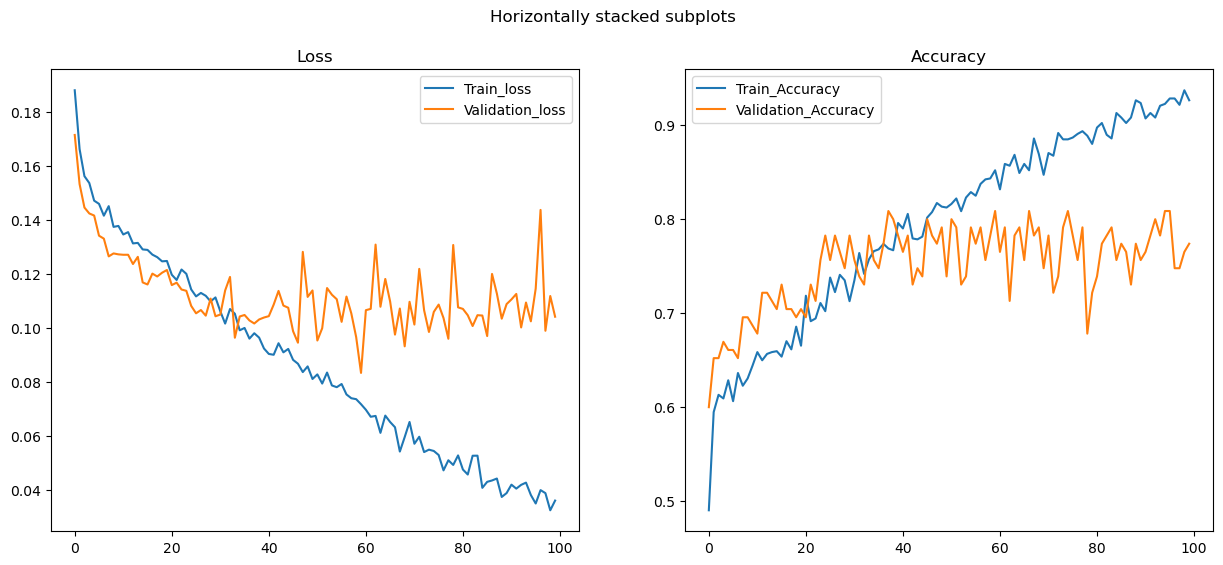

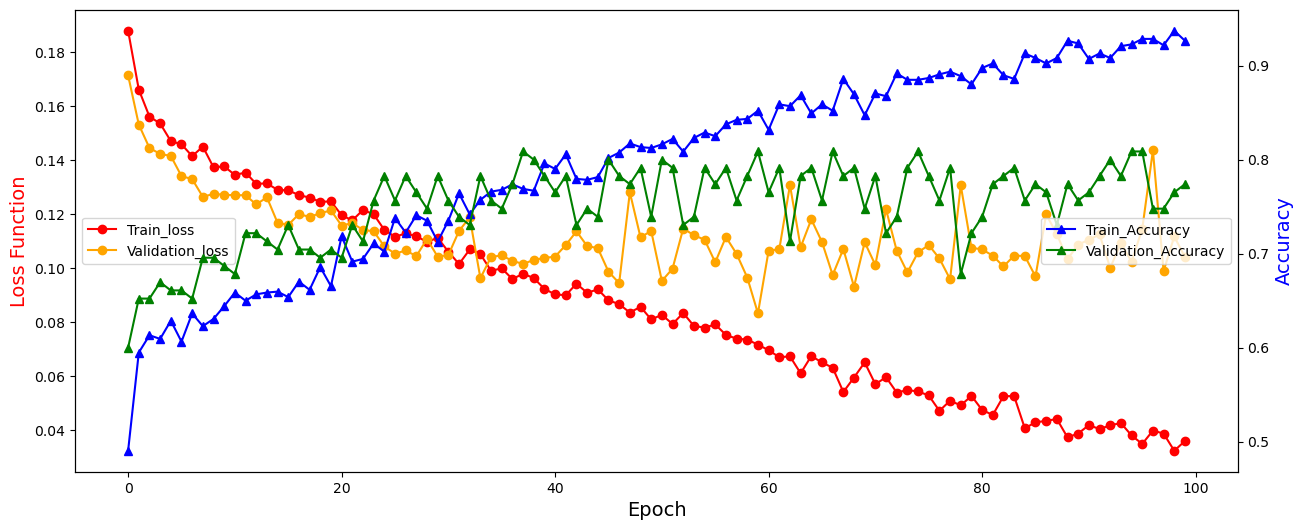

In [27]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

# Save Model

In [28]:
# Save Model
NAME = "model_1.pt"
NAME2 = "model_2.pt"

torch.save(model_bbox, PATH+NAME)
torch.save(modelpy, PATH+NAME2)

# Load Models

In [29]:
#model_bbox = Model_BBOX().to(device)
# Load the model
NAME = "model_1.pt"
#model_bbox.load_state_dict(torch.load(PATH+NAME, map_location=device))
model_bbox = torch.load(PATH+NAME, map_location=device)
model_bbox.eval()

# Define the Target Layers, for CAM
target_layers = [model_bbox.inception5b.branch4]

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model_bbox, target_layers=target_layers, use_cuda=torch.cuda.is_available())#



#modelpy = ClassificationNet().to(device)
# Load the model
NAME = "model_2.pt"
#modelpy.load_state_dict(torch.load(PATH+NAME, map_location=device))
modelpy = torch.load(PATH+NAME, map_location=device)
modelpy.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

# Evaluate model

In [30]:
  
def accuracy_given_set(mm1, mm2, valid_loader, cam, device, name="Validation"):
    # Evaluate the Validation Set
    mm1.eval()
    mm2.eval()
    correct = 0
    total = 0
    for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images, _ = get_cropped_img_batch_base_on_CAM(data[0].to(device), device, cam, threshold = BBOX_THRESHOLD)#.to(device)
        new_images = new_images.to(device)
        with torch.no_grad():
            
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)

        total += data[1].size(0)
        correct +=(predictions == data[1].to(device)).sum().item()
        
    print(f'Accuracy of the network on the {total} {name} instances: {100 * correct / total}%')

In [31]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(model_bbox, modelpy, train_loader, cam, device, name="Train")
accuracy_given_set(model_bbox, modelpy, valid_loader, cam, device, name="Validation")

100%|██████████| 173/173 [01:12<00:00,  2.38it/s]


Accuracy of the network on the 1034 Train instances: 98.74274661508704%


100%|██████████| 20/20 [00:07<00:00,  2.52it/s]

Accuracy of the network on the 115 Validation instances: 77.3913043478261%


# Plot images and Bbox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Img shape: (400, 400, 3)
Bbox pred: [130. 157. 263. 256.]
Label real: 0
Size of img: (400, 400, 3)


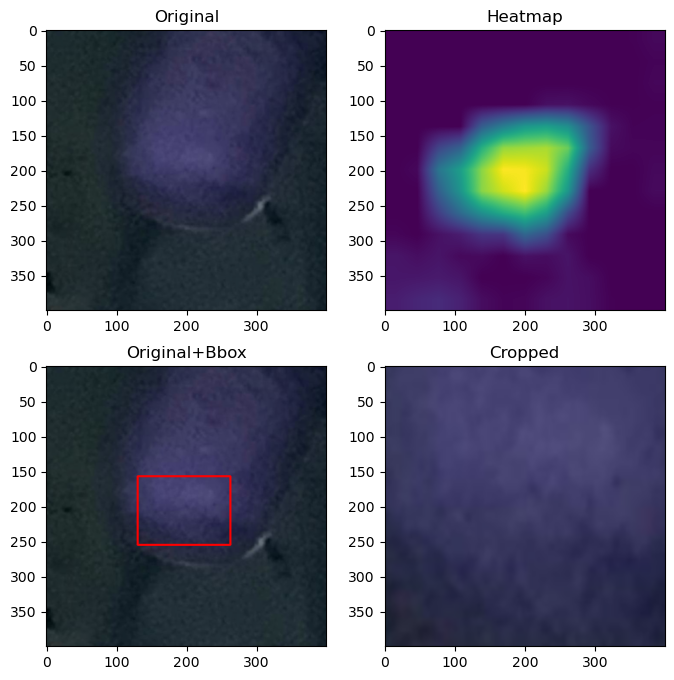

In [32]:
img_number = 1
# Create heatmap and Bbox
real_img, real_label, pred_heat, pred_box =get_true_values_and_predictions(model_bbox, val_Dataset, img_number, cam, threshold=BBOX_THRESHOLD)
# Compose img of real img+Bbox and croped Image
rr, rr_crop = create_img_and_bbox_with_pred(real_img, pred_box)

# Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(8,8))
ax1.imshow(real_img)
ax1.title.set_text("Original")
ax2.imshow(pred_heat)
ax2.title.set_text("Heatmap")
ax3.imshow(rr)
ax3.title.set_text("Original+Bbox")
ax4.imshow(rr_crop)
ax4.title.set_text("Cropped")
plt.show()

# Make Test Predictions

In [33]:
# Import the data 
test_data, test_labels = import_test_folder_dataset(test_data_path)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_labels.shape)

Dim of Data:  (380,)
Dim of Lables:  (380,)


C:\Users\Alex\Jupyter NoteBook Master\IA Master\Fall 2022\Artificial Intelligence\Final Project\GoogleNet_CAM-Plus-ImgClass_v3\functions.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return( (np.array(img_data_files),np.array(img_data_names)) )


In [34]:
# Create the dataset object
test_Dataset = Data_test(test_data, test_labels, img_transform_val) # img_transform

print("Test len: ",len(test_Dataset))

Test len:  380


In [35]:
# Create the dataloaders
test_loader = DataLoader(
    test_Dataset, 
    batch_size=1,             
    shuffle=False)

In [36]:
 
def make_predictions(mm1, mm2, loader, cam, device):
    # Evaluate the Validation Set
    mm1.eval()
    mm2.eval()
    predictions_list = []
    name_list = []
    
    box_list = []
    for bi, data in tqdm(enumerate(loader), total=len(loader)):
        # Use model_bbox model to get the new cropped images basen on CAM
        new_images, box = get_cropped_img_batch_base_on_CAM(data[0].to(device), device, cam, threshold = BBOX_THRESHOLD)#.to(device)
        new_images = new_images.to(device)
        with torch.no_grad():
            
            outputs = mm2(new_images)
            predictions = torch.argmax(outputs, dim=1)
        
        predictions_list.append(predictions[0].item())
        name_list.append(data[1][0])
        box_list.append(box[0])
        
    return(predictions_list, name_list, box_list)

In [37]:
pred, names, boxes = make_predictions(model_bbox, modelpy, test_loader, cam, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:38<00:00,  9.87it/s]


(array([0, 1, 2]), array([154, 159,  67], dtype=int64))

In [40]:
save_predictions_as_csv(names, pred, name="GGCv3_plus_clas_v02_GoogLeNet_prediction.csv")

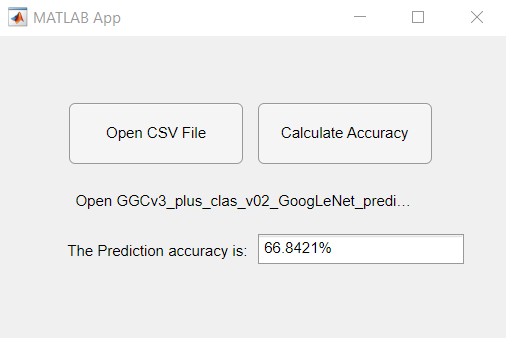

# Load Best Model

In [41]:
# Load the model
NAME1 = "model_1_bestModel.pt"
model_bbox_bestModel = torch.load(PATH+NAME1, map_location=device)
model_bbox_bestModel.eval()

# Define the Target Layers, for CAM
target_layers_bestModel = [model_bbox_bestModel.inception5b.branch4]

# Construct the CAM object once, and then re-use it on many images:
cam_bestModel = GradCAM(model=model_bbox_bestModel, target_layers=target_layers_bestModel, use_cuda=torch.cuda.is_available())#



# Load the model
NAME2 = "model_2_bestModel.pt"
modelpy_bestModel = torch.load(PATH+NAME2, map_location=device)
modelpy_bestModel.eval()

ClassificationNet(
  (googlenet_fe): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0

## Evaluate Best Model

In [42]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(model_bbox_bestModel, modelpy_bestModel, train_loader, cam_bestModel, device, name="Train")
accuracy_given_set(model_bbox_bestModel, modelpy_bestModel, valid_loader, cam_bestModel, device, name="Validation")

100%|██████████| 173/173 [02:44<00:00,  1.05it/s]


Accuracy of the network on the 1034 Train instances: 87.04061895551257%


100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

Accuracy of the network on the 115 Validation instances: 80.8695652173913%


## Test Predictions Best Model

In [43]:
pred, names, boxes = make_predictions(model_bbox_bestModel, modelpy_bestModel, test_loader, cam_bestModel, device)

np.unique(np.array(pred),return_counts=True)

100%|██████████| 380/380 [00:40<00:00,  9.45it/s]


(array([0, 1, 2]), array([150, 174,  56], dtype=int64))

In [44]:
save_predictions_as_csv(names, pred, name="GGCv3_plus_clas_v02_GoogLeNet_best_prediction.csv")

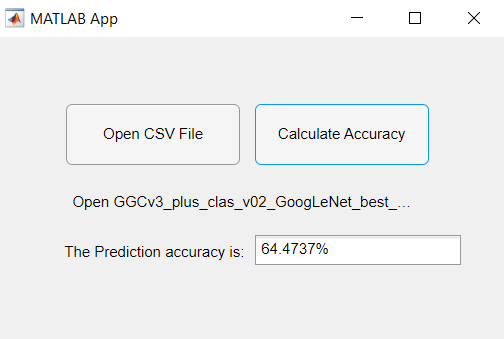